In [1]:
import scanpy as sc
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import sys

sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 3 

In [2]:
import session_info
session_info.show()

In [3]:
#load metadata file
meta = pd.read_csv('meta_latest.csv', index_col=0)

holder = []
for sample in meta.index:
    #read in the count matrix
    holder.append(sc.read_10x_mtx('/nfs/team205/ac65/cr2_2_samples/'+sample+'/soupx', cache=True))
    #add sample ID to barcodes
    holder[-1].obs_names = [sample+'_'+i for i in holder[-1].obs_names]
    #add metadata
    holder[-1].obs['sample'] = sample
    for col in meta.columns:
        holder[-1].obs[col] = meta.loc[sample, col]

#create joint object across all the samples
adata= holder[0].concatenate(holder[1:], index_unique=None)

... reading from cache file cache/nfs-team205-ac65-cr2_2_samples-CV001_KM10202573-soupx-matrix.h5ad
... reading from cache file cache/nfs-team205-ac65-cr2_2_samples-CV001_KM10202574-soupx-matrix.h5ad
... reading from cache file cache/nfs-team205-ac65-cr2_2_samples-CV001_KM10202575-soupx-matrix.h5ad
... reading from cache file cache/nfs-team205-ac65-cr2_2_samples-CV001_KM10202576-soupx-matrix.h5ad
... reading from cache file cache/nfs-team205-ac65-cr2_2_samples-CV001_KM10202577-soupx-matrix.h5ad
... reading from cache file cache/nfs-team205-ac65-cr2_2_samples-CV001_KM10202578-soupx-matrix.h5ad
... reading from cache file cache/nfs-team205-ac65-cr2_2_samples-CV001_KM10202579-soupx-matrix.h5ad
... reading from cache file cache/nfs-team205-ac65-cr2_2_samples-CV001_KM10202580-soupx-matrix.h5ad
... reading from cache file cache/nfs-team205-ac65-cr2_2_samples-CV001_KM10202581-soupx-matrix.h5ad
... reading from cache file cache/nfs-team205-ac65-cr2_2_samples-CV001_KM10202582-soupx-matrix.h5ad


In [3]:
adata

AnnData object with n_obs × n_vars = 289726 × 33559
    obs: 'sample', 'treatment', 'time', 'donor', 'sample_name', 'version', 'spike-in_primer', 'batch'
    var: 'gene_ids'

In [4]:
df = pd.read_csv("/nfs/team205/ac65/cr2_2_samples/scrublet_combined.csv", index_col="index")
df.index = df.index.astype(str)
df = df[~df.index.duplicated(keep='first')]
adata.obs = pd.concat([adata.obs, df], axis=1).reindex(adata.obs.index)

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='doublet_bh_pval', ylabel='Density'>

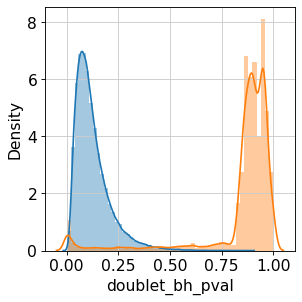

In [5]:
sns.distplot(adata.obs.scrublet_score)
sns.distplot(adata.obs.doublet_bh_pval)

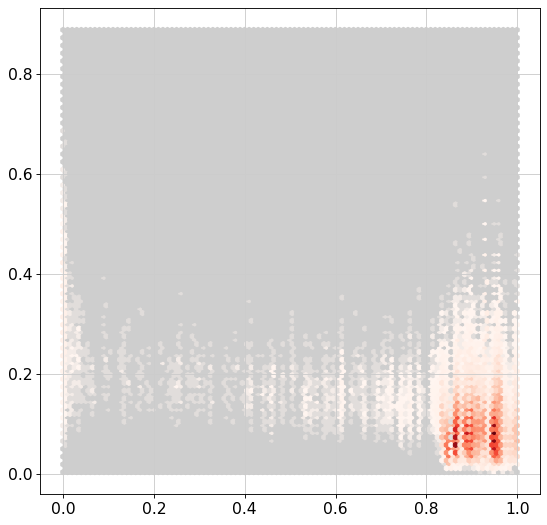

In [6]:
import sctk as sk
import matplotlib.pyplot as plt
sc.set_figure_params(figsize=(8, 8))
expr_cmap = sk.expression_colormap()
plt.hexbin(adata.obs.doublet_bh_pval, adata.obs.scrublet_score, cmap=expr_cmap);

In [7]:
adata.obs['doublet'] = (adata.obs.doublet_bh_pval < 0.8) | (adata.obs.scrublet_score > 0.3)
#Remove cells predicted to be doublets by scrublet (treshold 0.25)
adata = adata[adata.obs["doublet"]==False]

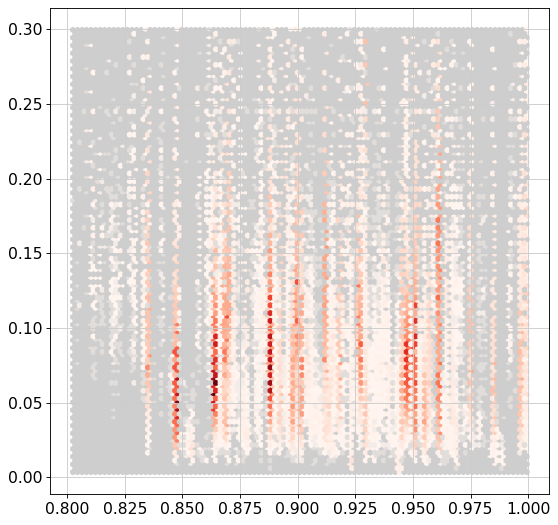

In [8]:
sc.set_figure_params(figsize=(8, 8))
expr_cmap = sk.expression_colormap()
plt.hexbin(adata.obs.doublet_bh_pval, adata.obs.scrublet_score, cmap=expr_cmap);

<AxesSubplot:xlabel='doublet_bh_pval', ylabel='Density'>

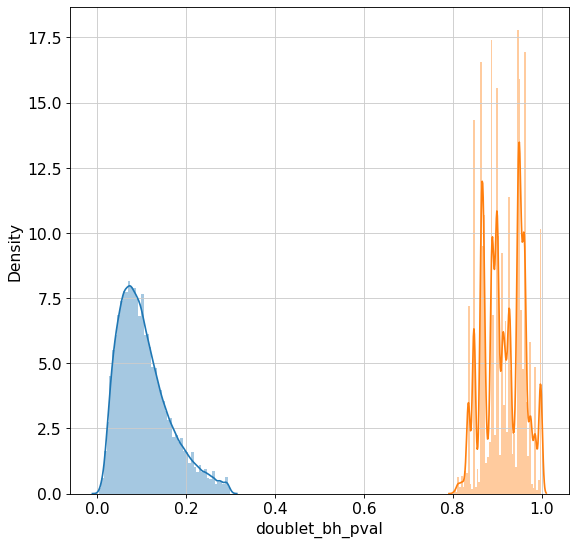

In [9]:
sns.distplot(adata.obs.scrublet_score)
sns.distplot(adata.obs.doublet_bh_pval)

In [10]:
adata

View of AnnData object with n_obs × n_vars = 247509 × 33559
    obs: 'sample', 'treatment', 'time', 'donor', 'sample_name', 'version', 'spike-in_primer', 'batch', 'scrublet_leiden', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'doublet'
    var: 'gene_ids'

In [11]:
sc.pp.filter_genes(adata, min_counts=3)

filtered out 7112 genes that are detected in less than 3 counts
Trying to set attribute `.var` of view, copying.


In [12]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

In [13]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [14]:
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))

In [15]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

... storing 'sample' as categorical
... storing 'treatment' as categorical
... storing 'time' as categorical
... storing 'donor' as categorical
... storing 'sample_name' as categorical
... storing 'version' as categorical
... storing 'spike-in_primer' as categorical
... storing 'scrublet_leiden' as categorical


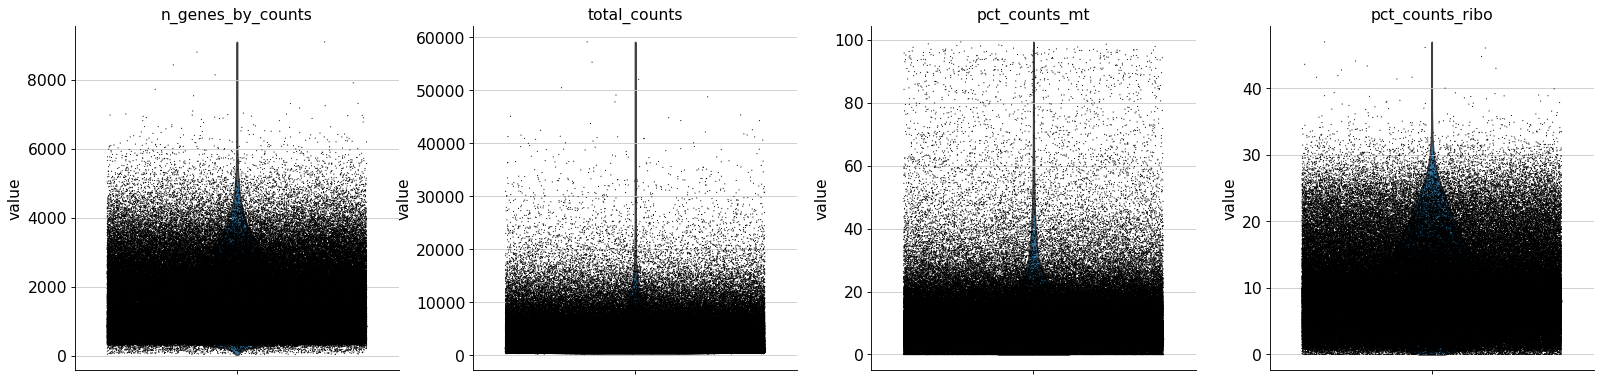

In [16]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

In [17]:
adata = adata[adata.obs.pct_counts_mt < 30, :]
#adata = adata[adata.obs.n_genes_by_counts < 4000, :]

Trying to set attribute `.uns` of view, copying.


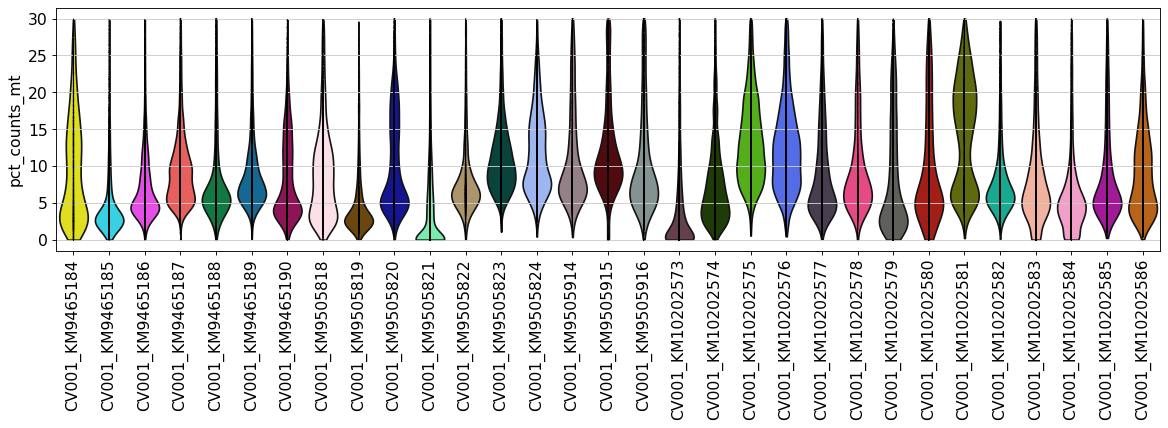

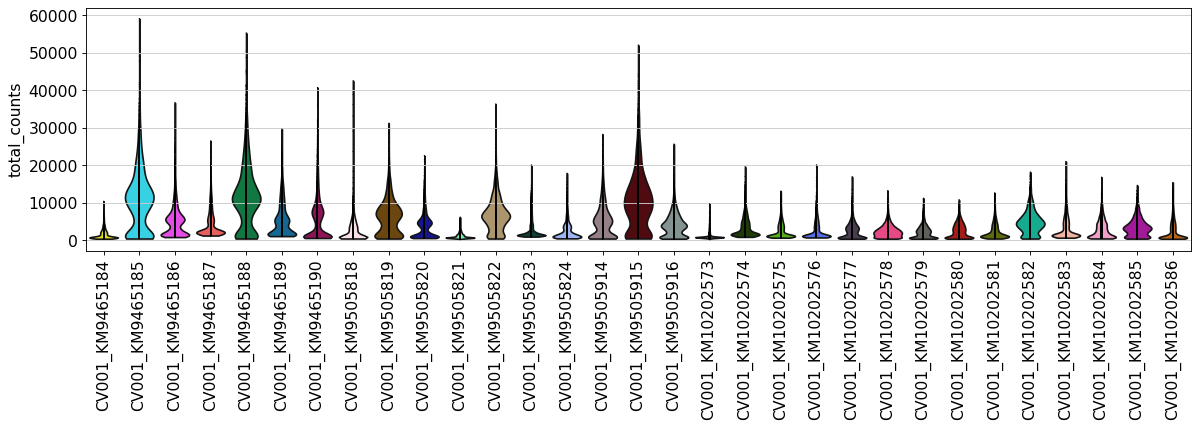

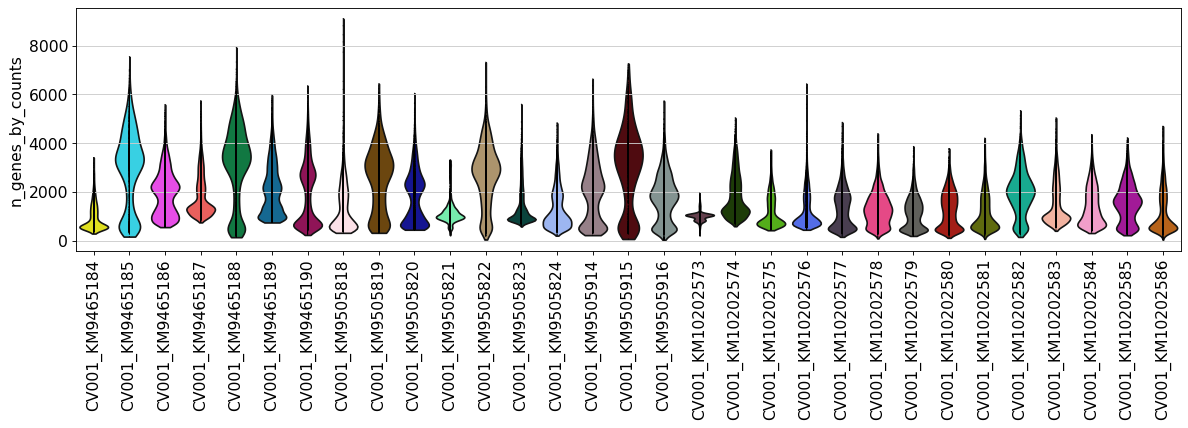

In [18]:
sc.set_figure_params(figsize=(14, 4))
sc.pl.violin(adata, ["pct_counts_mt"], groupby= "sample", rotation=90, jitter=False)
sc.pl.violin(adata, ["total_counts"], groupby= "sample", rotation=90, jitter=False)
sc.pl.violin(adata, ["n_genes_by_counts"], groupby= "sample", rotation=90, jitter=False)

In [33]:
adata.write("adata_cr2_singlets.h5ad")

In [2]:
adata = sc.read_h5ad("adata_cr2_singlets.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 237302 × 26447
    obs: 'sample', 'treatment', 'time', 'donor', 'sample_name', 'version', 'spike-in_primer', 'batch', 'scrublet_leiden', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'
    uns: 'sample_colors'

In [4]:
sc.set_figure_params(figsize=(3, 3))

In [5]:
samples = np.unique(adata.obs['sample'])

In [6]:
#prepare two obs columns in the object - one for the souporcell clusters, one for the genotype
#(all singlet values will be overwritten. all untouched fields are non-singlet)
adata.obs['souporcell_cluster'] = 'non-singlet'
adata.obs['genotype'] = 'non-singlet'

#loop over the samples
for sample in samples:
    #import souporcell output
    df = pd.read_table('/nfs/team205/ac65/souporcell_latest/'+sample+'/clusters.tsv', index_col=0)
    #alter index to match scanpy object
    df.index = [sample+'_'+i for i in df.index]
    #identify the cells that the souporcell output has in common with the object
    cells = list(set(df.index).intersection(set(adata.obs_names)))
    #rename the clusters to match formatting in genotype spreadsheet
    df['assignment'] = [sample+'_cluster_'+i for i in df['assignment']]
    #stick this pre-genotype form into the scanpy object just in case
    adata.obs.loc[cells, 'souporcell_cluster'] = df.loc[cells,'assignment']
    #stick the calls into the scanpy object
    adata.obs.loc[cells, 'genotype'] = df.loc[cells,'status']  

In [7]:
adata.obs

,sample,treatment,time,donor,sample_name,version,spike-in_primer,batch,scrublet_leiden,scrublet_score,...,doublet_bh_pval,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,souporcell_cluster,genotype
CV001_KM10202573_AAACCTGAGCTAAACA,CV001_KM10202573,control,nan,ALI2,ALI2_control_v1.1,v1.1,spike-in_LOW,0,"10,6",0.230143,...,0.959324,False,1010,854.656494,92.476936,10.820363,74.354477,8.699925,CV001_KM10202573_cluster_3,singlet
CV001_KM10202573_AAACCTGAGGAGTCTG,CV001_KM10202573,control,nan,ALI2,ALI2_control_v1.1,v1.1,spike-in_LOW,0,"2,22",0.140449,...,0.929572,False,1107,967.876831,6.240196,0.644730,82.007721,8.472950,CV001_KM10202573_cluster_0/2,unassigned
CV001_KM10202573_AAACCTGAGTCGTACT,CV001_KM10202573,control,nan,ALI2,ALI2_control_v1.1,v1.1,spike-in_LOW,0,"0,71",0.127130,...,0.946518,False,1078,795.643188,0.000000,0.000000,78.025421,9.806584,CV001_KM10202573_cluster_0,unassigned
CV001_KM10202573_AAACCTGAGTGTTAGA,CV001_KM10202573,control,nan,ALI2,ALI2_control_v1.1,v1.1,spike-in_LOW,0,"2,31",0.180438,...,0.967663,False,1153,886.886047,0.000000,0.000000,65.399582,7.374068,CV001_KM10202573_cluster_2,singlet
CV001_KM10202573_AAACCTGCATGCGCAC,CV001_KM10202573,control,nan,ALI2,ALI2_control_v1.1,v1.1,spike-in_LOW,0,"7,5",0.220472,...,0.967663,False,895,1080.132690,141.647934,13.113938,19.327858,1.789397,CV001_KM10202573_cluster_0,unassigned
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CV001_KM9505916_TTTGTCATCACGATGT,CV001_KM9505916,SARS,72h,ALI3,ALI3_SARS_72h_V2,v2,spike-in_HIGH,30,"0,5",0.220339,...,0.922660,False,1480,2611.079102,262.215332,10.042413,227.407578,8.709333,CV001_KM9505916_cluster_2,singlet
CV001_KM9505916_TTTGTCATCCCATTAT,CV001_KM9505916,SARS,72h,ALI3,ALI3_SARS_72h_V2,v2,spike-in_HIGH,30,"2,0",0.129771,...,0.937426,False,1571,3220.570801,172.535034,5.357281,616.526855,19.143402,CV001_KM9505916_cluster_0,singlet
CV001_KM9505916_TTTGTCATCCGGGTGT,CV001_KM9505916,SARS,72h,ALI3,ALI3_SARS_72h_V2,v2,spike-in_HIGH,30,"3,5",0.065327,...,0.985310,False,2861,9856.480469,100.517784,1.019814,948.763733,9.625786,CV001_KM9505916_cluster_1,singlet
CV001_KM9505916_TTTGTCATCGGCATCG,CV001_KM9505916,SARS,72h,ALI3,ALI3_SARS_72h_V2,v2,spike-in_HIGH,30,"5,8",0.045936,...,0.985310,False,989,1494.020020,166.303650,11.131287,40.078308,2.682582,CV001_KM9505916_cluster_0/3,doublet


In [8]:
#prepare the genotype calls - read in the correlations
genotype = pd.read_csv('/nfs/team205/ac65/souporcell_latest/correlation_cluster_genotypes.csv', index_col=0)
#identify the column name with the highest value for each row, so the proposed genotype
genotype['genotype'] = genotype.idxmax(axis=1)

#loop over the samples
for sample in samples:
    #import souporcell output
    df = pd.read_table('/nfs/team205/ac65/souporcell_latest/'+sample+'/clusters.tsv', index_col=0)
    #alter index to match scanpy object
    df.index = [sample+'_'+i for i in df.index]
    #limit to just the singlets
    df = df.loc[df['status']== 'singlet',:]
    #identify the cells that the souporcell output has in common with the object
    cells = list(set(df.index).intersection(set(adata.obs_names)))
    #rename the clusters to match formatting in genotype spreadsheet
    df['assignment'] = [sample+'_cluster_'+i for i in df['assignment']]
    #stick this pre-genotype form into the scanpy object just in case
    adata.obs.loc[cells, 'souporcell_cluster'] = df.loc[cells,'assignment']
    #rename the clusters to their corresponding genotypes
    df['genotype'] = [genotype.loc[i,'genotype'] for i in df['assignment']]
    #stick the calls into the scanpy object
    adata.obs.loc[cells, 'genotype'] = df.loc[cells,'genotype']
 

In [9]:
adata.obs      

,sample,treatment,time,donor,sample_name,version,spike-in_primer,batch,scrublet_leiden,scrublet_score,...,doublet_bh_pval,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,souporcell_cluster,genotype
CV001_KM10202573_AAACCTGAGCTAAACA,CV001_KM10202573,control,nan,ALI2,ALI2_control_v1.1,v1.1,spike-in_LOW,0,"10,6",0.230143,...,0.959324,False,1010,854.656494,92.476936,10.820363,74.354477,8.699925,CV001_KM10202573_cluster_3,UCL_6
CV001_KM10202573_AAACCTGAGGAGTCTG,CV001_KM10202573,control,nan,ALI2,ALI2_control_v1.1,v1.1,spike-in_LOW,0,"2,22",0.140449,...,0.929572,False,1107,967.876831,6.240196,0.644730,82.007721,8.472950,CV001_KM10202573_cluster_0/2,unassigned
CV001_KM10202573_AAACCTGAGTCGTACT,CV001_KM10202573,control,nan,ALI2,ALI2_control_v1.1,v1.1,spike-in_LOW,0,"0,71",0.127130,...,0.946518,False,1078,795.643188,0.000000,0.000000,78.025421,9.806584,CV001_KM10202573_cluster_0,unassigned
CV001_KM10202573_AAACCTGAGTGTTAGA,CV001_KM10202573,control,nan,ALI2,ALI2_control_v1.1,v1.1,spike-in_LOW,0,"2,31",0.180438,...,0.967663,False,1153,886.886047,0.000000,0.000000,65.399582,7.374068,CV001_KM10202573_cluster_2,UCL_6
CV001_KM10202573_AAACCTGCATGCGCAC,CV001_KM10202573,control,nan,ALI2,ALI2_control_v1.1,v1.1,spike-in_LOW,0,"7,5",0.220472,...,0.967663,False,895,1080.132690,141.647934,13.113938,19.327858,1.789397,CV001_KM10202573_cluster_0,unassigned
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CV001_KM9505916_TTTGTCATCACGATGT,CV001_KM9505916,SARS,72h,ALI3,ALI3_SARS_72h_V2,v2,spike-in_HIGH,30,"0,5",0.220339,...,0.922660,False,1480,2611.079102,262.215332,10.042413,227.407578,8.709333,CV001_KM9505916_cluster_2,UCL_11
CV001_KM9505916_TTTGTCATCCCATTAT,CV001_KM9505916,SARS,72h,ALI3,ALI3_SARS_72h_V2,v2,spike-in_HIGH,30,"2,0",0.129771,...,0.937426,False,1571,3220.570801,172.535034,5.357281,616.526855,19.143402,CV001_KM9505916_cluster_0,UCL_12
CV001_KM9505916_TTTGTCATCCGGGTGT,CV001_KM9505916,SARS,72h,ALI3,ALI3_SARS_72h_V2,v2,spike-in_HIGH,30,"3,5",0.065327,...,0.985310,False,2861,9856.480469,100.517784,1.019814,948.763733,9.625786,CV001_KM9505916_cluster_1,UCL_9
CV001_KM9505916_TTTGTCATCGGCATCG,CV001_KM9505916,SARS,72h,ALI3,ALI3_SARS_72h_V2,v2,spike-in_HIGH,30,"5,8",0.045936,...,0.985310,False,989,1494.020020,166.303650,11.131287,40.078308,2.682582,CV001_KM9505916_cluster_0/3,doublet


In [10]:
sum(adata.obs["genotype"] == "unassigned")

58339

In [11]:
sum(adata.obs["genotype"] == "doublet")

21414

In [12]:
adata.obs.loc[adata.obs["souporcell_cluster"] == "CV001_KM10202573_cluster_2", 'genotype'] = "UCL_8"

In [13]:
adata.obs.loc[adata.obs["souporcell_cluster"] == "CV001_KM10202573_cluster_3", 'genotype'] = "UCL_10"

In [14]:
adata.obs.loc[adata.obs["souporcell_cluster"] == "CV001_KM10202575_cluster_2", 'genotype'] = "UCL_8"

In [15]:
adata.obs.loc[adata.obs["souporcell_cluster"] == "CV001_KM10202576_cluster_3", 'genotype'] = "UCL_8"

In [16]:
adata.obs.loc[adata.obs["souporcell_cluster"] == "CV001_KM10202579_cluster_0", 'genotype'] = "UCL_8"

In [17]:
adata.obs.loc[adata.obs["souporcell_cluster"] == "CV001_KM10202580_cluster_0", 'genotype'] = "UCL_8"

In [18]:
adata.obs.loc[adata.obs["souporcell_cluster"] == "CV001_KM10202583_cluster_3", 'genotype'] = "UCL_8"

In [19]:
adata.obs.loc[adata.obs["souporcell_cluster"] == "CV001_KM10202584_cluster_2", 'genotype'] = "UCL_8"

In [20]:
adata.obs['group'] = 'Paediatric'

In [21]:
adata.obs.loc[adata.obs["genotype"] == 'UCL_3','group'] = 'Adult'

In [22]:
adata.obs.loc[adata.obs["genotype"] == 'UCL_10','group'] = 'Adult'

In [23]:
adata.obs.loc[adata.obs["genotype"] == 'UCL_11','group'] = 'Adult'

In [24]:
adata.obs.loc[adata.obs["genotype"] == 'UCL_12','group'] = 'Adult'

In [25]:
adata.obs.loc[adata.obs["genotype"] == 'UCL_4','group'] = 'Elderly'

In [26]:
adata.obs.loc[adata.obs["genotype"] == 'UCL_5','group'] = 'Elderly'

In [27]:
adata.obs.loc[adata.obs["genotype"] == 'UCL_6','group'] = 'Elderly'

In [28]:
adata.obs.loc[adata.obs["genotype"] == 'UCL_7','group'] = 'Elderly'

In [29]:
adata.obs['gender'] = 'Female'

In [30]:
adata.obs.loc[adata.obs["genotype"] == 'UCL_1','gender'] = 'Male'
adata.obs.loc[adata.obs["genotype"] == 'UCL_3','gender'] = 'Male'
adata.obs.loc[adata.obs["genotype"] == 'UCL_4','gender'] = 'Male'
adata.obs.loc[adata.obs["genotype"] == 'UCL_7','gender'] = 'Male'
adata.obs.loc[adata.obs["genotype"] == 'UCL_8','gender'] = 'Male'
adata.obs.loc[adata.obs["genotype"] == 'UCL_9','gender'] = 'Male'

In [31]:
adata = adata[adata.obs.genotype != 'unassigned']

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [32]:
adata = adata[adata.obs.genotype != 'doublet']
adata

View of AnnData object with n_obs × n_vars = 158006 × 26447
    obs: 'sample', 'treatment', 'time', 'donor', 'sample_name', 'version', 'spike-in_primer', 'batch', 'scrublet_leiden', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'souporcell_cluster', 'genotype', 'group', 'gender'
    var: 'gene_ids', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'
    uns: 'sample_colors'

In [33]:
adata.write("adata_cr2_singlets_genotype.h5ad")

/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'souporcell_cluster' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'genotype' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'group' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'gender' as categorical


In [2]:
adata = sc.read_h5ad("adata_cr2_singlets_genotype.h5ad")

In [3]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:01)


In [4]:
adata

AnnData object with n_obs × n_vars = 158006 × 26447
    obs: 'sample', 'treatment', 'time', 'donor', 'sample_name', 'version', 'spike-in_primer', 'batch', 'scrublet_leiden', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'souporcell_cluster', 'genotype', 'group', 'gender'
    var: 'gene_ids', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'
    uns: 'sample_colors'

In [5]:
sc.pp.log1p(adata)

In [6]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:08)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [7]:
adata.raw = adata

In [8]:
sc.pp.scale(adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [9]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
    with n_comps=50
    finished (0:00:37)


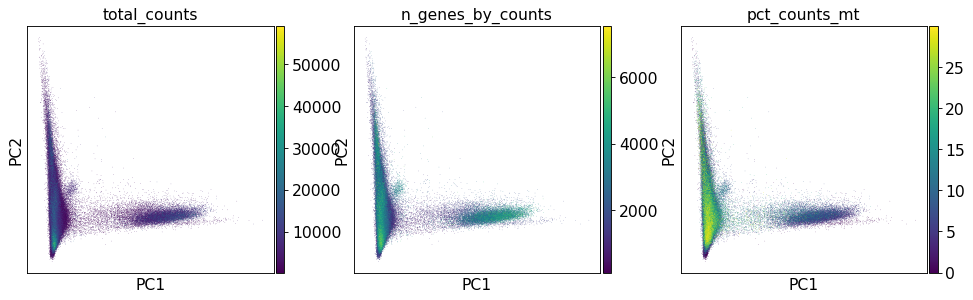

In [10]:
sc.set_figure_params(figsize=(4, 4))
sc.pl.pca(adata, color=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'])

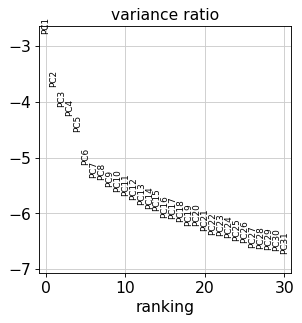

In [11]:
sc.pl.pca_variance_ratio(adata, log=True)

In [12]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:43)


In [13]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:29)


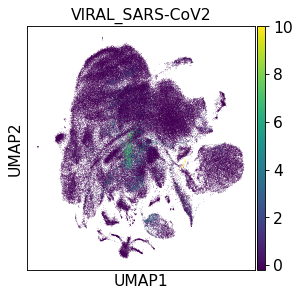

In [14]:
sc.set_figure_params(figsize=(4, 4))
sc.pl.umap(adata, color=['VIRAL_SARS-CoV2'], use_raw=False)

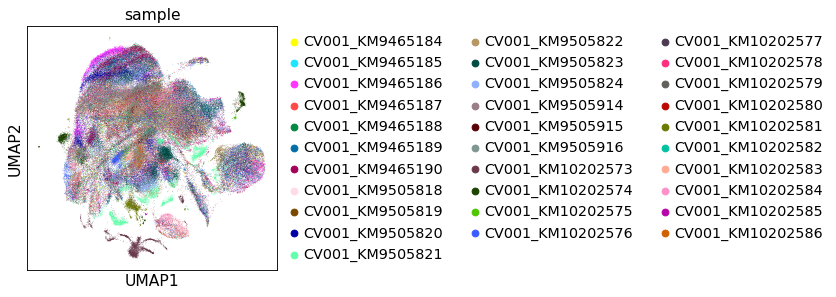

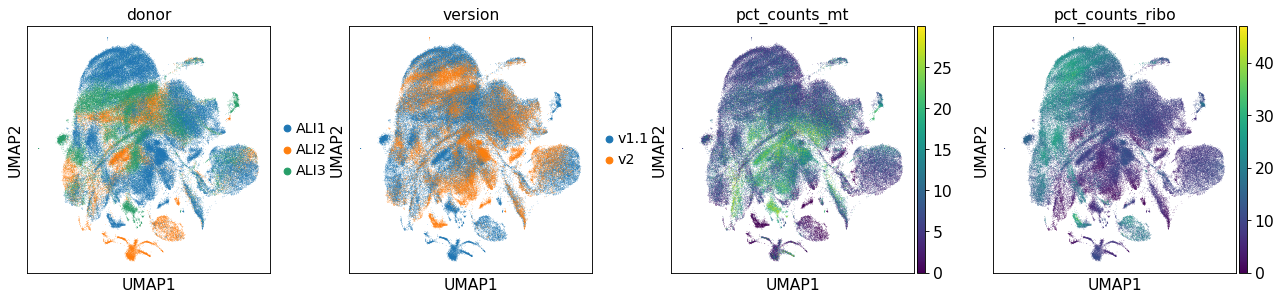

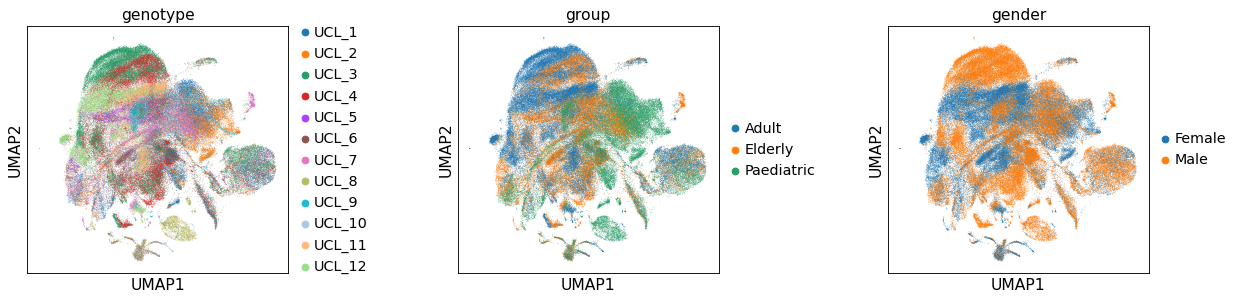

In [15]:
sc.set_figure_params(figsize=(4, 4))
sc.pl.umap(adata, color='sample')
sc.pl.umap(adata, color=['donor', 'version', "pct_counts_mt", "pct_counts_ribo"])
sc.pl.umap(adata, color=['genotype', 'group', 'gender'], wspace = 0.5)

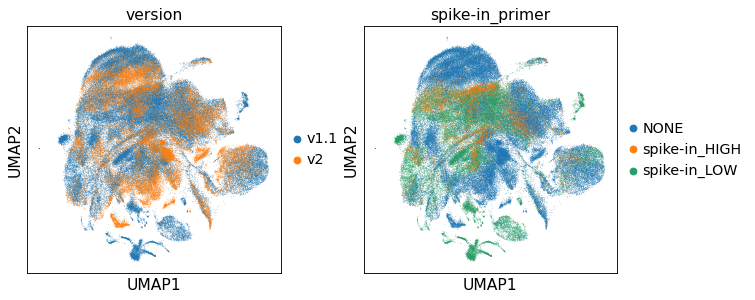

In [16]:
sc.set_figure_params(figsize=(4, 4))
sc.pl.umap(adata, color=['version', 'spike-in_primer'])

In [18]:
adata

AnnData object with n_obs × n_vars = 158006 × 26447
    obs: 'sample', 'treatment', 'time', 'donor', 'sample_name', 'version', 'spike-in_primer', 'batch', 'scrublet_leiden', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'souporcell_cluster', 'genotype', 'group', 'gender'
    var: 'gene_ids', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'sample_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'donor_colors', 'version_colors', 'genotype_colors', 'group_colors', 'gender_colors', 'spike-in_primer_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [ ]:
adata.write('adata_cr2_singlets_genotype.h5ad')